# Tutorial (Image Data Processing)

(Last updated: Jan 29, 2024)[^credit]

[^credit]: Credit: this teaching material is created by Bryan Fleming under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

Here is an online version of [this notebook in Google Colab](https://colab.research.google.com/drive/17eDq0aIYNRipcjpZ6SApMUtcCPpyOvlQ?usp=sharing). This online version is just for browsing. To work on this notebook, you need to copy a new one to your own Google Colab.

This tutorial will guide you through the entire pipeline for training an image classifier using PyTorch and deep neural networks.

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=fdd6e06da0c525824e00d40be306cec53e4fb0803ca1195d991b09af2a74d93a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
!pip install torch

In [3]:
!pip install pydot

In [4]:
!pip install pydotplus

In [5]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=1d84fd2df25fec866bb90f930325a45e134e899c86d336fff9184666feec23f9
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


In [6]:
# Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.autograd import Variable
from torchviz import make_dot
from IPython.display import Image
import base64
import matplotlib.pyplot as plt
import warnings
from IPython.display import HTML
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

**First, you need to enable GPUs for the notebook in Google Colab:**

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # use CUDA device
else:
    device = torch.device("cpu")           # use CPU device
device

device(type='cuda')

Make sure that the ouput from the above cell is `device(type='cuda')`. If you see `device(type='cpu')`, it means that you did not enable GPU usage on Google Colab. Go to [this page](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html) and check the "Use GPU as an accelerator" part for details. Please be patient for this tutorial and the assignment, as training neural networks for Computer Vision tasks typically takes a lot of time.

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Scenario

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/images/tablet.jpg?raw=true)

Image source -- https://www.istockphoto.com/nl/foto/ancient-text-gm139879372-1545295

As an aspiring machine learning enthusiast, you have been presented with a unique challenge. A team of archeologists has discovered an ancient text written on a mysterious tablet that nobody has ever seen before. The script on this is so complex that no one has been able to decipher it, even after months of studying it.

However, you have a hunch that machine learning could be used to decipher the tablets script. You have been tasked with converting the ancient script into a string of modern numbers, as it is suspected to be some kind of Mathematical Algorithm - you're tasked with turning the script into a dataset that can be used to train a machine learning model. To do this, you will need to organize the ancient symbols into 10 classes, one for each digit, and label them accordingly.

To train the machine learning model, you will be using the MNIST dataset, which is a well-known benchmark dataset for image classification. Once you have organized the ancient symbols into classes, you can use the MNIST dataset to train the machine learning model to recognize the symbols.

With the help of the machine learning model, your colleagues will be able to classify the symbols in the ancient text and decipher the secrets of an ancient civilization that have been lost for centuries. This task requires creativity, persistence, and attention to detail, but with the power of machine learning, you have the opportunity to unlock a new understanding of an ancient culture and make a significant contribution to the field of archeology.

You will be provided with all the sufficient resources to carry out this task, good luck!

## A Simple Linear Algorithm

This notebook will help you understand and create an algorithm which will learn how to recognize ancient symbols, and convert them to the modern decimal system, your colleagues will then have the task of converting the rest of the symbols to other modern mathematical operators, with the end goal of discovering the secrets of this Ancient Civilization.

Below we will lay out the code for a simple, 1-layer linear network, whose goal is to classify the ancient digits, using our modern decimal system:

In [9]:
# First, we define the transforms for the data.

transforms = transforms.Compose([
    transforms.ToTensor(), # this converts our data convert to torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize the data, these are the Mean and STD of this dataset respectively
])

In [10]:
# Next we will load the MNIST dataset, which we use to train the network.
# NOTE: In the assignment, we will not use a dataset in this library, so we will show you alternate methods to load a dataset.

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 309891856.44it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37926015.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 190352620.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 866011.85it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
# Next we define the dataloaders.

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
trainloader = DeviceDataLoader(trainloader, device) # move the training data loader to the device
testloader = DeviceDataLoader(testloader, device) # move the validation data loader to the device

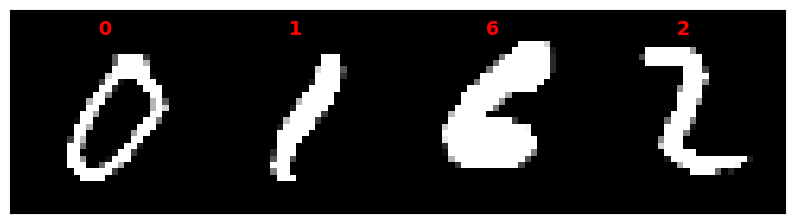

In [12]:
# Visualizing the Data:

warnings.filterwarnings("ignore")

# Load the MNIST dataset and apply normalization
mnist_data = datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=4, shuffle=True)

# Display a batch of images
for images, labels in data_loader:
    # Create a grid of images
    grid_image = utils.make_grid(images, nrow=4).permute(1, 2, 0)

    # Center the label text
    label_text = [str(label.item()).center(4) for label in labels]

    # Display the image grid and labels
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(grid_image, cmap='gray', vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(min(4, len(label_text))):
        # Calculate the position of the label text
        x = (2 * i + 1) * grid_image.shape[1] // 8
        y = grid_image.shape[0] // 32

        # Add the label text to the image
        ax.text(x, y, label_text[i], color='red', fontsize=14, fontweight='bold', ha='center', va='top')

    plt.show()
    break

In [13]:
# Now we define the Networks 'architecture', this is essentially the Algorithm you've heard so much about.

class VerySimpleNet(nn.Module):
    def __init__(self):
        super(VerySimpleNet, self).__init__()
        # The thing to focus on is the self.fc1 - and how we define this transformation.
        # It is a linear function of size 28*28, due to the image's pixels, and also 10 after, as there is 10 classes.
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

# Here you see how the model evolves
# - flattening the tensor
# - putting our data through the linear function
# - outputting a classification via log_softmax

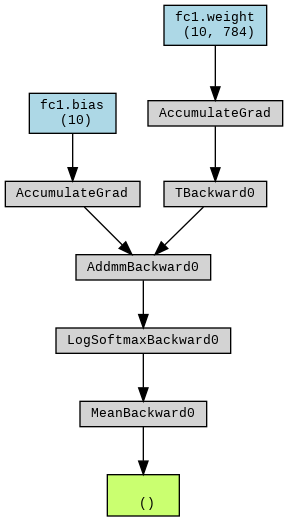

In [14]:
# Now we will do what we call 'initializing' the network and optimizer.
# We effectively tell it how to 'learn', to correct itself by changing the weights of nodes in the network with what we call a loss function.

very_simple_net = VerySimpleNet()
criterion = nn.NLLLoss()
optimizer = optim.SGD(very_simple_net.parameters(), lr=0.01, momentum=0.9)

# We wish to visualize:
# Create a sample input tensor
x = torch.randn(1, 1, 28, 28)
x = Variable(x)
# Pass the input tensor through the network and calculate the output
y = very_simple_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(very_simple_net.named_parameters()))
dot.format = 'png'
dot.render(filename='net_graph1')

# Display the computation graph in Jupyter Notebook
Image(filename='net_graph1.png')

In [15]:
# Now we actually train the network, so we can test it's effectiveness.

very_simple_net = to_device(very_simple_net, device) # move the model to the device (CPU or GPU)
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = very_simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished training')

[1,   100] loss: 0.555
[1,   200] loss: 0.355
[1,   300] loss: 0.358
[1,   400] loss: 0.343
[1,   500] loss: 0.333
[1,   600] loss: 0.313
[1,   700] loss: 0.336
[1,   800] loss: 0.352
[1,   900] loss: 0.313
[2,   100] loss: 0.334
[2,   200] loss: 0.295
[2,   300] loss: 0.317
[2,   400] loss: 0.295
[2,   500] loss: 0.306
[2,   600] loss: 0.299
[2,   700] loss: 0.306
[2,   800] loss: 0.301
[2,   900] loss: 0.301
[3,   100] loss: 0.307
[3,   200] loss: 0.285
[3,   300] loss: 0.291
[3,   400] loss: 0.294
[3,   500] loss: 0.309
[3,   600] loss: 0.292
[3,   700] loss: 0.285
[3,   800] loss: 0.301
[3,   900] loss: 0.281
[4,   100] loss: 0.307
[4,   200] loss: 0.275
[4,   300] loss: 0.283
[4,   400] loss: 0.290
[4,   500] loss: 0.299
[4,   600] loss: 0.296
[4,   700] loss: 0.293
[4,   800] loss: 0.300
[4,   900] loss: 0.286
[5,   100] loss: 0.279
[5,   200] loss: 0.294
[5,   300] loss: 0.276
[5,   400] loss: 0.266
[5,   500] loss: 0.300
[5,   600] loss: 0.300
[5,   700] loss: 0.293
[5,   800] 

In [16]:
# Lastly, we evaluate the network on the test data, this code is quite easy to understand.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = very_simple_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 91 %


## A Simple NN (The perfect algorithm?)

Now, 90% classification rate is good, for most purposes, but for the task at hand, we will need something just short of perfection - time for a more complex network!

As you (should) have learned from your lectures and the course so far, there is phenomenon we call over-fitting and under-fitting, which happens when we use a model too simple or too complex for the data at hand.

We then know, that there should exist a perfect algorithm, which exists in the space below an over-fit model, and above an under-fit model, although it is near impossible to get to this 'perfect' model, we can simply stop once it's what we consider, adequete, lets do our best to find this not-so-perfect model then.

Below you will find, what we would call a simple Convolutional (Neural) Network (CNN), not quite deep learning, but the architecture is getting more complex. With this improved model, we would hope for higher accuracy, lets test this out.

In [17]:
# Network architecture

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(32*13*13, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

Some new functions have been introduced here, convolution. A convolution here is what we will call a 'matrix sliding operation' we input the image and a small matrix of numbers called a kernel (matrix much smaller than the image).

To perform a convolution operation, we slide the kernel over the image, starting at the top left corner, and perform a series of element-wise multiplications and summations. At each location, we multiply the values in the kernel by the corresponding values in the image, and sum up the results. We then store the result in the output image at the corresponding location, it is a smaller matrix than the image, as we have 'contracted' values into a smaller space, essentially, that is the idea of a convolution.

By doing this for every location in the input image, we can create a new output image that has been filtered or transformed in some way based on the kernel - the image below will make this much more obvious:

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/images/convolution.png?raw=true)

Image source -- https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/convnet-notebook.html

You'll notice however, we have also introduced something called Max Pooling, this is similar to a convolution, but it's primary goal is to reduce the dimensionality (size) of the feature maps produced by a layer of our CNN.

The basic idea behind max pooling is to divide the feature map into non-overlapping regions, and then take the maximum value of each region as the output.

To perform max pooling, we first select a region of the feature map (usually a small rectangle) and then find the maximum value in that region. We then store the maximum value in a new output feature map at the corresponding location.

By repeating this process for each non-overlapping region in the feature map, we can create a new output feature map that is smaller than the input feature map. This process can be thought of as "pooling" the information from the input feature map, since we are reducing the amount of information by selecting only the maximum values, similar to convolutions as mentioned before!

See below an image which describes Max Pooling:

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/images/max-pooling.png?raw=true)

Image source -- https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/

Now, just as before, we are now going to have to initialize the network, and it's criterion and optimizer, now that you have seen it before, I should explain these a bit better:

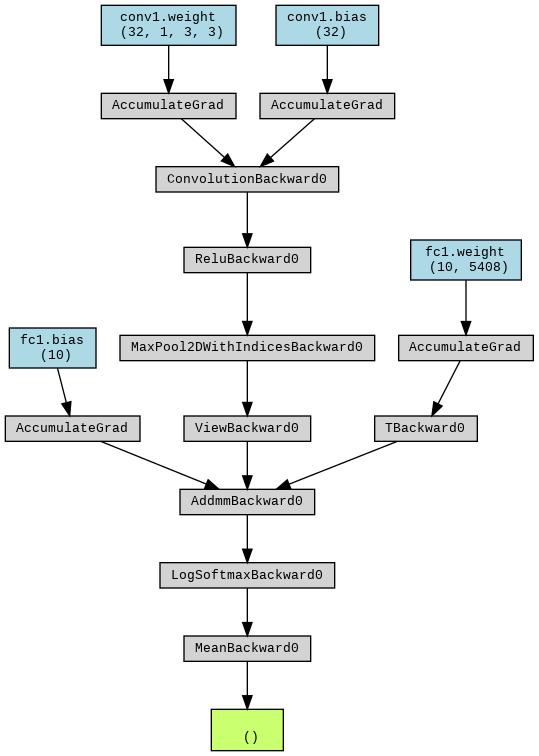

In [18]:
# Again, 'initializing' the network and optimizer, we effectively tell it how to 'learn', to correct itself by changing the weights of nodes in the network with what we call a loss function.
simple_net = SimpleNet()
criterion = nn.NLLLoss()
optimizer = optim.SGD(simple_net.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(1, 1, 28, 28)
x = Variable(x)
# Pass the input tensor through the network and calculate the output
y = simple_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(simple_net.named_parameters()))
dot.format = 'png'
dot.render(filename='net_graph2')

# Display the computation graph in Jupyter Notebook
Image(filename='net_graph2.png')

Here, the 'criterion' is is used to compute the loss or error between the predicted output of a model and the actual output. During training, the model updates its parameters based on the value of the loss computed by the criterion. PyTorch provides several built-in criterion classes, such as nn.MSELoss for mean squared error and nn.CrossEntropyLoss for multi-class classification; or in our case:

nn.NLLLoss - negative log likelihood, here our 'target' is a tensor of class labels which are true, we have our loss defined as the negative of the log-probabilities for each tensorial input (for every tensor value we have a unique loss, ignore the technical jargon). You simply take the log of the probability of each value of the input tensor (we can use nn.LogSoftmax for this for example).

On the other hand, the optimizer is how we actually use this 'loss' to update the parameters of the model, we usually use optim.Adam or optim.SGD, 'Adam' (adaptive moment estimation) is essentially a more adaptive SGD (stochastic gradient descent), where the learning rate is updated based on the loss function and parameters. We use SGD over 'Adam' if our data is noisy or if we have a shallow network (like this one), as in these cases SGD converges faster - in most other cases 'Adam' converges much faster.

Both of these try approach optimal parameter values by going towards the negative gradient we get from the loss function, multiplied by the learning rate, and reducing the parameter values by such.

Now we will train the model, as before:

In [19]:
# Training

simple_net = to_device(simple_net, device) # move the model to the device (CPU or GPU)
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished training')

[1,   100] loss: 0.524
[1,   200] loss: 0.245
[1,   300] loss: 0.179
[1,   400] loss: 0.144
[1,   500] loss: 0.136
[1,   600] loss: 0.126
[1,   700] loss: 0.118
[1,   800] loss: 0.101
[1,   900] loss: 0.090
[2,   100] loss: 0.074
[2,   200] loss: 0.076
[2,   300] loss: 0.077
[2,   400] loss: 0.070
[2,   500] loss: 0.071
[2,   600] loss: 0.073
[2,   700] loss: 0.071
[2,   800] loss: 0.068
[2,   900] loss: 0.072
[3,   100] loss: 0.058
[3,   200] loss: 0.054
[3,   300] loss: 0.057
[3,   400] loss: 0.048
[3,   500] loss: 0.052
[3,   600] loss: 0.052
[3,   700] loss: 0.057
[3,   800] loss: 0.061
[3,   900] loss: 0.061
[4,   100] loss: 0.042
[4,   200] loss: 0.039
[4,   300] loss: 0.044
[4,   400] loss: 0.047
[4,   500] loss: 0.042
[4,   600] loss: 0.057
[4,   700] loss: 0.053
[4,   800] loss: 0.049
[4,   900] loss: 0.050
[5,   100] loss: 0.034
[5,   200] loss: 0.036
[5,   300] loss: 0.035
[5,   400] loss: 0.043
[5,   500] loss: 0.038
[5,   600] loss: 0.045
[5,   700] loss: 0.039
[5,   800] 

Training was completed above, nothing new here, we will again test the accuracy of the model, we are hoping for a marginal increase in accuracy, given we have complexified the model - see below the accuracy test:

In [20]:
# Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = simple_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 98 %


This is quite the increase, seemingly, it is worth it to increase the complexity, lets test out this hypothesis; I won't be explaining much, what follows is more for you to interpret, and make your own conclusions - please ask if you have questions!

## The Elusive CNN (As good as it gets?)

In [21]:
# Network architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

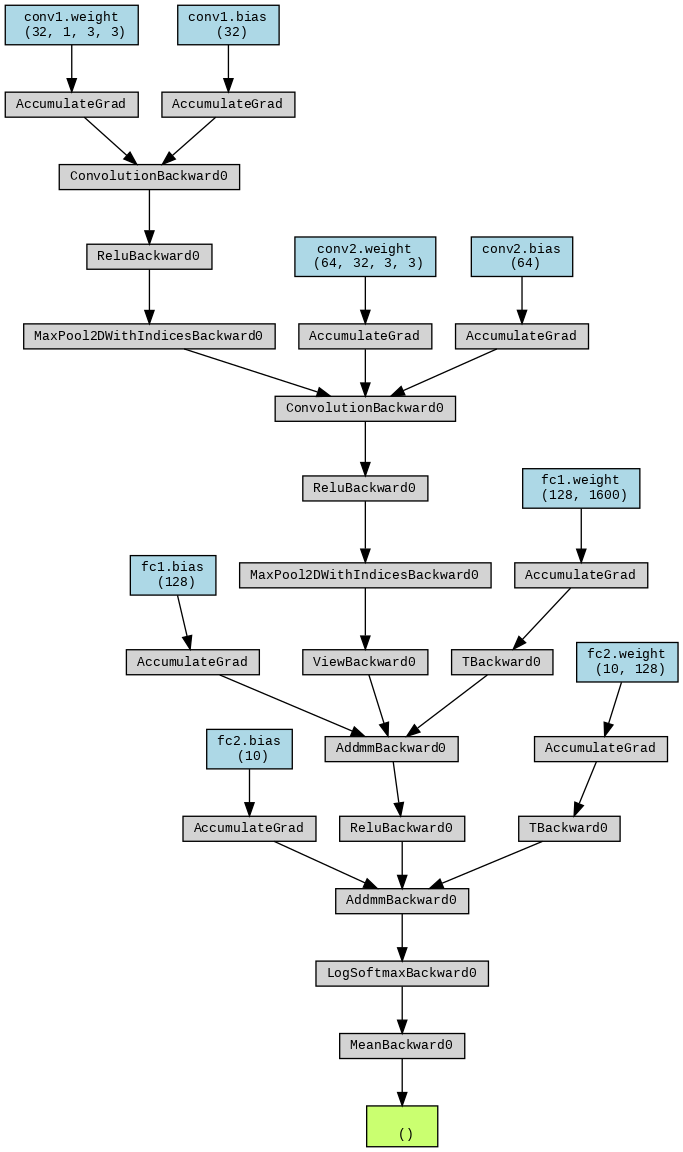

In [22]:
# Initializing the network

net = Net()
criterion = nn.CrossEntropyLoss() # Note the change here
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(1, 1, 28, 28)
x = Variable(x)
# Pass the input tensor through the network and calculate the output
y = net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(net.named_parameters()))
dot.format = 'png'
dot.render(filename='net_graph3')

# Display the computation graph in Jupyter Notebook
Image(filename='net_graph3.png')

In [23]:
# Training

net = to_device(net, device) # move the model to the device (CPU or GPU)
for epoch in range(7):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished training')

[1,   100] loss: 0.909
[1,   200] loss: 0.205
[1,   300] loss: 0.142
[1,   400] loss: 0.123
[1,   500] loss: 0.116
[1,   600] loss: 0.091
[1,   700] loss: 0.079
[1,   800] loss: 0.062
[1,   900] loss: 0.073
[2,   100] loss: 0.062
[2,   200] loss: 0.057
[2,   300] loss: 0.060
[2,   400] loss: 0.060
[2,   500] loss: 0.051
[2,   600] loss: 0.050
[2,   700] loss: 0.043
[2,   800] loss: 0.055
[2,   900] loss: 0.041
[3,   100] loss: 0.037
[3,   200] loss: 0.032
[3,   300] loss: 0.038
[3,   400] loss: 0.043
[3,   500] loss: 0.038
[3,   600] loss: 0.035
[3,   700] loss: 0.028
[3,   800] loss: 0.036
[3,   900] loss: 0.033
[4,   100] loss: 0.017
[4,   200] loss: 0.028
[4,   300] loss: 0.023
[4,   400] loss: 0.029
[4,   500] loss: 0.028
[4,   600] loss: 0.029
[4,   700] loss: 0.026
[4,   800] loss: 0.030
[4,   900] loss: 0.026
[5,   100] loss: 0.022
[5,   200] loss: 0.019
[5,   300] loss: 0.025
[5,   400] loss: 0.021
[5,   500] loss: 0.020
[5,   600] loss: 0.026
[5,   700] loss: 0.017
[5,   800] 

In [24]:
# Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 99 %


Surely this is about as good as it gets accuracy wise, or is it?

## The complex CNN (Perfection?)

In [25]:
# Network architecture

class complexNet(nn.Module):
    def __init__(self):
        super(complexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 512, 3, 1)
        self.conv2 = nn.Conv2d(512, 512, 3, 1)
        self.fc1 = nn.Linear(512*5*5, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = nn.functional.relu(x)
        x = self.fc5(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

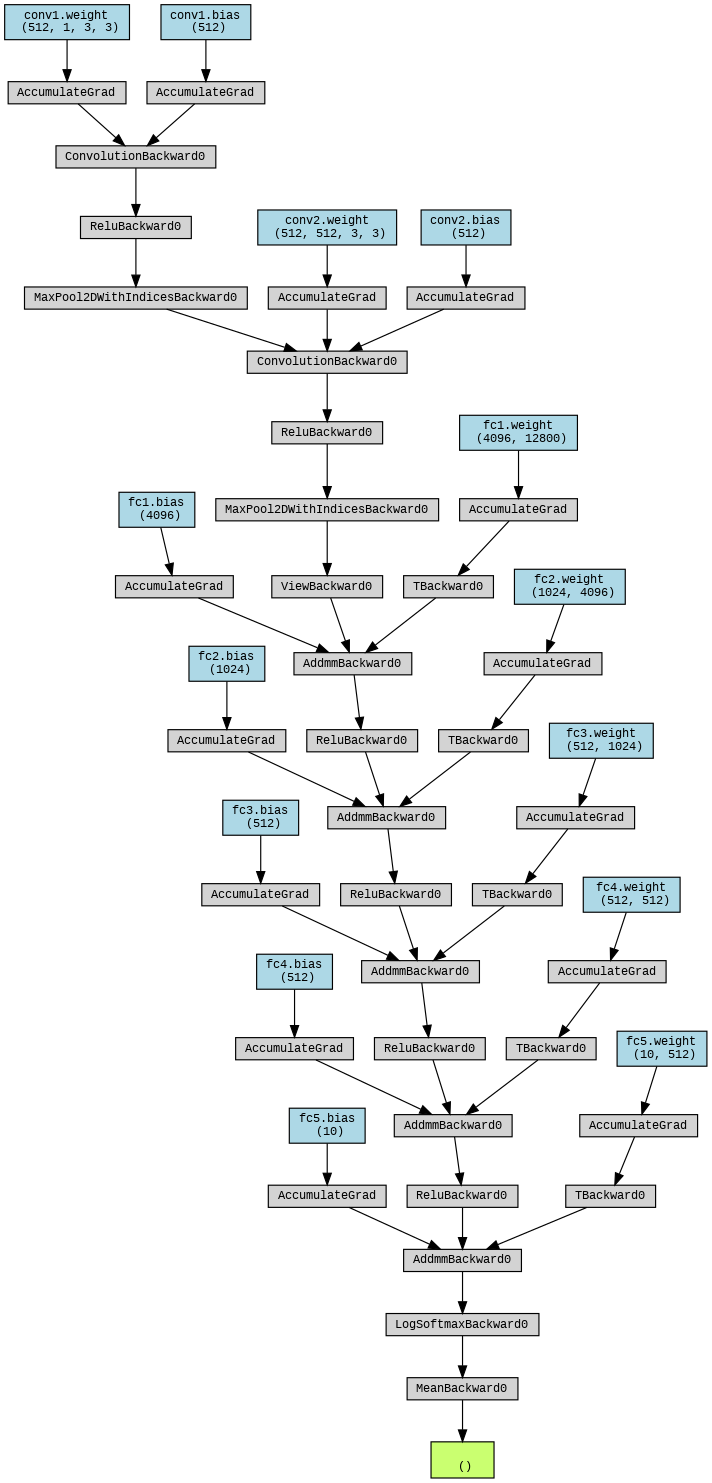

In [26]:
# Initiatializing the Network

complex_net = complexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(complex_net.parameters(), lr=0.0001)

x = torch.randn(1, 1, 28, 28)
x = Variable(x)
# Pass the input tensor through the network and calculate the output
y = complex_net(x)

# Create a visualization of the computation graph
dot = make_dot(y.mean(), params=dict(complex_net.named_parameters()))
dot.format = 'png'
dot.render(filename='net_graph4')

# Display the computation graph in Jupyter Notebook
Image(filename='net_graph4.png')

In [27]:
# Training

complex_net = to_device(complex_net, device) # move the model to the device (CPU or GPU)
for epoch in range(15):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = complex_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished training')

[1,   100] loss: 0.694
[1,   200] loss: 0.166
[1,   300] loss: 0.116
[1,   400] loss: 0.098
[1,   500] loss: 0.085
[1,   600] loss: 0.087
[1,   700] loss: 0.079
[1,   800] loss: 0.071
[1,   900] loss: 0.061
[2,   100] loss: 0.051
[2,   200] loss: 0.048
[2,   300] loss: 0.046
[2,   400] loss: 0.049
[2,   500] loss: 0.050
[2,   600] loss: 0.044
[2,   700] loss: 0.047
[2,   800] loss: 0.049
[2,   900] loss: 0.033
[3,   100] loss: 0.038
[3,   200] loss: 0.032
[3,   300] loss: 0.026
[3,   400] loss: 0.029
[3,   500] loss: 0.031
[3,   600] loss: 0.033
[3,   700] loss: 0.030
[3,   800] loss: 0.035
[3,   900] loss: 0.036
[4,   100] loss: 0.017
[4,   200] loss: 0.027
[4,   300] loss: 0.025
[4,   400] loss: 0.025
[4,   500] loss: 0.032
[4,   600] loss: 0.019
[4,   700] loss: 0.019
[4,   800] loss: 0.025
[4,   900] loss: 0.023
[5,   100] loss: 0.018
[5,   200] loss: 0.020
[5,   300] loss: 0.019
[5,   400] loss: 0.017
[5,   500] loss: 0.020
[5,   600] loss: 0.021
[5,   700] loss: 0.021
[5,   800] 

In [28]:
# Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = complex_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 98 %


What do you think about this model?

## Explainability
Apart from performance, another feature to take into account when developing an AI system is its **explainability**, i.e., the ability to show why the model makes decissions in the way it does.

Explainability is important for several reasons. Having explanations for a model's decissions not only helps building trust on them, but also increases productivity when debugging the model or tackling areas of improvement.

In recent years, new techniques have been developed to improve explainability in complex ML models. We will have a look at [GradCAM](https://arxiv.org/abs/1610.02391), a model that provides class gradient maps for CNNs of different architectures. The function `display_grad_cam` computes and displays the GradCAMs of a batch of images for a given method:

In [29]:
def scale_to_01(arr):
    """
    Scales an array so all its values lie in the interval [0, 1].

    Parameters
    ----------
    arr : numpy.array
        The original array.

    Returns
    -------
    numpy.array
        The sclaed array.
    """
    min_val = arr.min()
    max_val = arr.max()
    scaled_array = (arr - min_val) / (max_val - min_val)
    return scaled_array


def display_grad_cam(model, target_layers, images):
    """
    Computes and displays the GradCAM for a convolutional neural network for a
    batch of images.

    Parameters
    ----------
    model : nn.Module
        Model on which we want to compute the GradCAM.
    target_layers : List[nn.Module]
        List of convolutional layers where the GradCAM is computed. If a list
        with several layers is provided, the CAM will be averaged accross them.
    images: torch.Tensor
        Batch of images for which the GradCAM shall be computed.

    """
    # Appply GradCAM to the images
    grad_cam = GradCAM(model=model, target_layers=target_layers)
    cams = grad_cam(input_tensor=images,
                    targets=None,
                    aug_smooth=True,
                    eigen_smooth=True)

    # Convert images to numpy arrays and scale them to [0,1]. This step is
    # necessary for the show_cam_on_image funciton to work
    images = scale_to_01(np.array(images.permute(0, 2, 3, 1).cpu()))

    # Merge each image with its cam
    cam_images = []
    for image, cam in zip(images, cams):
        cam_images.append(show_cam_on_image(image, cam, use_rgb=True))
    cam_images = torch.tensor(cam_images)

    # Display grid with cams of all images in the batch
    grid_image = utils.make_grid(cam_images.permute(0, 3, 1, 2), nrow=8).permute(1, 2, 0)

    plt.title("Model: " + model.__class__.__name__)
    plt.axis("off")
    plt.imshow(grid_image, vmin=0, vmax=1)
    plt.show()

Let's display some GradCAMS for all the convolutional networks that we have trained. It is common to select the **last convolutional layer** as target layer, but feel free to try it out with other layers (or a combination of them).

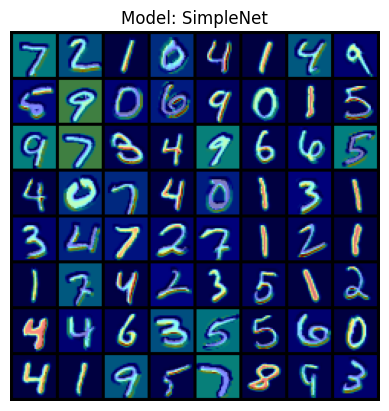

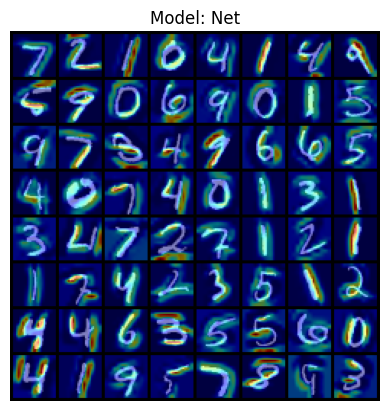

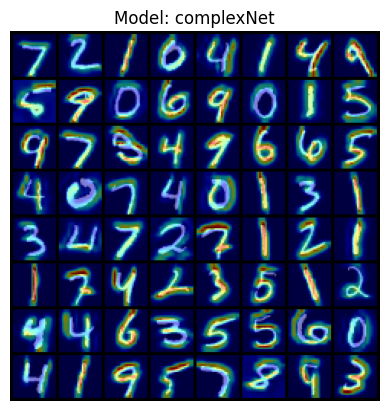

In [30]:
# Get a batch of (64) images
images, _ = next(iter(testloader))

# Display GradCAM on the last convolutional layer of each model
for model, target_layers in [(simple_net, [simple_net.conv1]),
                           (net, [net.conv2]),
                           (complex_net, [complex_net.conv2])]:
    model.eval()
    display_grad_cam(model, target_layers, images)

The plots show the cams on top of the original images. The GradCAMs use a redder color on the pixels that are more relevant for the classification decission, and bluer on the ones that are less relevant.


What differences can you spot between the explanations for the different models?

![](https://github.com/MultiX-Amsterdam/image-data-module/blob/main/images/icarus.jpg?raw=true)

Image source -- https://www.greekmythologyinart.com/the-fall-of-icarus-gowy.html

Which one of these models will you use to decode the ancient tablet? Are any of them good enough? Briefly explain why you picked the model you did, so you can justify to your colleagues why they will continue working further with it!